In [1]:
import numpy as np
import seaborn as sns
import os 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scanpy as sc
import pandas as pd
np.random.seed(0)

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map='viridis')
sc.logging.print_header()
sc.settings.savefigs = False  

2023-01-27 20:51:34.516331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 20:51:35.293562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/christos/miniconda3/envs/ml/lib/
2023-01-27 20:51:35.293650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/christos/miniconda3/envs/ml/lib/
2023-01-27 20:51:35.293659: W tensorflow/compiler/

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.8


In [3]:
Root_Folder = "/home/christos/Desktop/Traj_Inf"#Please adapt root folder accordingly.
os.chdir(Root_Folder)

In [4]:
#Dataset filenames
filename_mESC ='./data/Gastr/Rna_scNMT_gastr.tsv'
#_mESC is used to denote mouse Embryonic stem cells publised by Argelaguet (Multi-omics profiling of mouse gastrulation at single-cell resolution)

In [5]:
%%time
#Load Datasets and add embryonic day metadata
adata_mESC = sc.read(filename_mESC,cache=True).transpose()
Days = [xx.split('_')[0] for xx in list(adata_mESC.obs_names)]
adata_mESC.obs["E_days"] = Days
sc.logging.print_memory_usage()

... reading from cache file cache/data-Gastr-Rna_scNMT_gastr.h5ad
Memory usage: current 0.84 GB, difference +0.84 GB
CPU times: user 514 ms, sys: 131 ms, total: 645 ms
Wall time: 643 ms


# Quality Control

In [6]:
#Estimate QC metrics for the data.
sc.pp.calculate_qc_metrics(adata_mESC, percent_top=None, log1p=False, inplace=True)

In [7]:
#Filter out genes that are not expressed in any cell and normalize datasets

sc.pp.filter_genes(adata_mESC, min_cells = 1)
sc.pp.normalize_per_cell(adata_mESC)# normalize _mESC with total UMI count per cell
adata_mESC=adata_mESC[adata_mESC.obs["E_days"]!='PS']

filtered out 816 genes that are detected in less than 1 cells
normalizing by total count per cell
filtered out 5 cells that have less than 1 counts
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [8]:
#Keep 5000 genes with the highest dispersion.

filter_result_mESC = sc.pp.filter_genes_dispersion(adata_mESC.X, flavor='cell_ranger', n_top_genes=5000, log=False)
sc.pp.filter_genes_dispersion(adata_mESC, flavor='cell_ranger', n_top_genes=5000, log=False)


extracting highly variable genes
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:129: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['means'] = result['means']


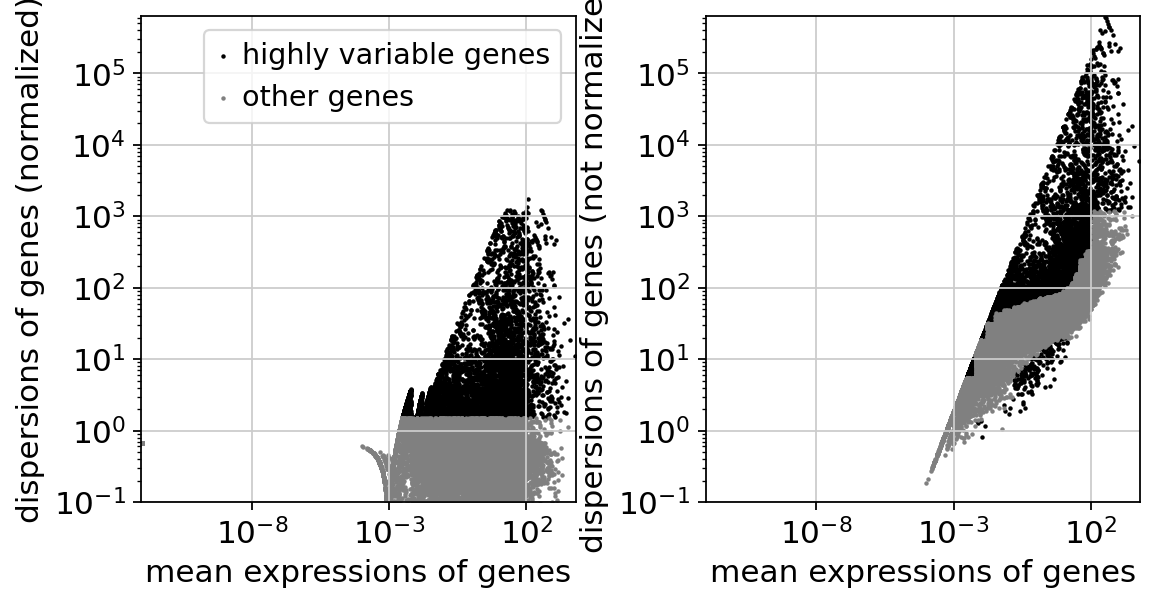

In [9]:
sc.pl.filter_genes_dispersion(filter_result_mESC, log=True)

# Preprocessing

In [10]:
%%time
sc.pp.scale(adata_mESC) #scale _mESC data

CPU times: user 68.8 ms, sys: 4.15 ms, total: 73 ms
Wall time: 71.4 ms


computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:04)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


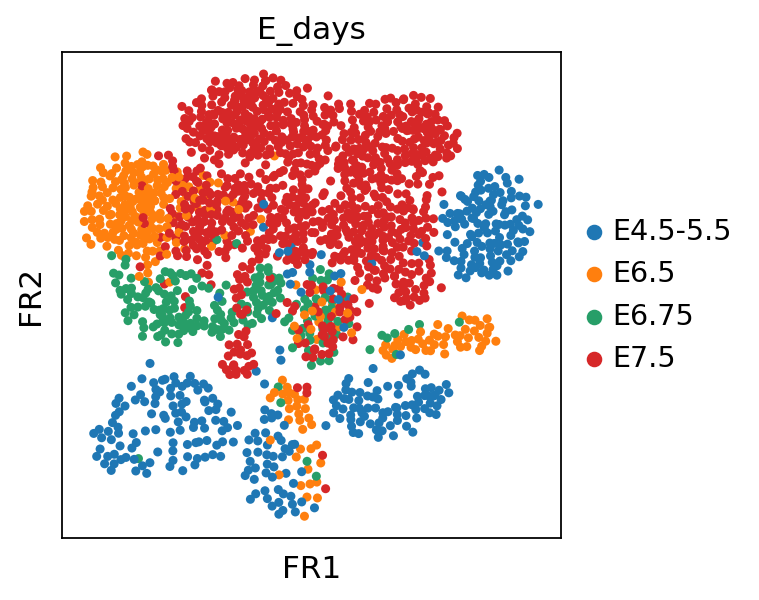

Memory usage: current 0.67 GB, difference -0.16 GB


In [11]:
#Estimating low dimensional embeddings with PCA and Umap
sc.tl.pca(adata_mESC, n_comps=50,random_state=0)
sc.pp.neighbors(adata_mESC, n_neighbors=20, n_pcs=50,random_state=0)
sc.tl.draw_graph(adata_mESC)
sc.pl.draw_graph(adata_mESC, color='E_days')
sc.logging.print_memory_usage()

# Denoise the graph

In [12]:
sc.tl.diffmap(adata_mESC)
sc.pp.neighbors(adata_mESC, n_neighbors=20,random_state=0, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99390966 0.993714   0.9921671  0.9914513  0.9902903
     0.98384356 0.9747106  0.96016663 0.9543249  0.94078404 0.93811005
     0.9348909  0.9318193  0.9295409 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [13]:
sc.tl.draw_graph(adata_mESC)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:04)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


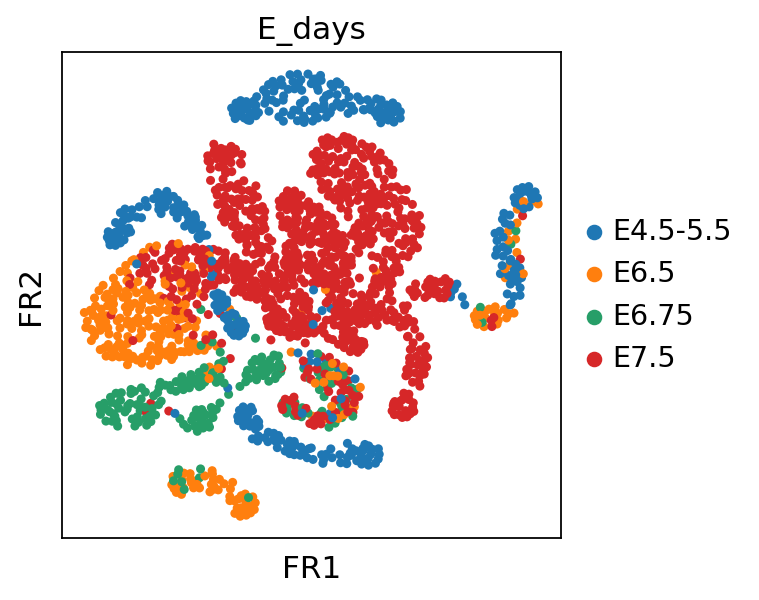

In [14]:
sc.pl.draw_graph(adata_mESC, color='E_days')

# Clustering and PAGA

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


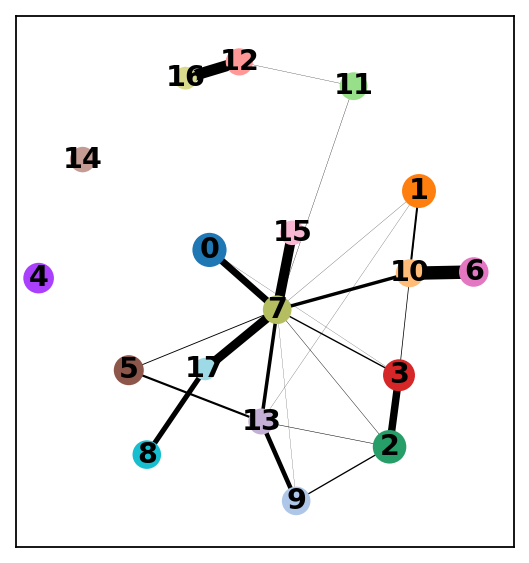

In [15]:
sc.tl.louvain(adata_mESC, resolution=1.0)
sc.tl.paga(adata_mESC, groups='louvain')
sc.pl.paga(adata_mESC, color='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes: >

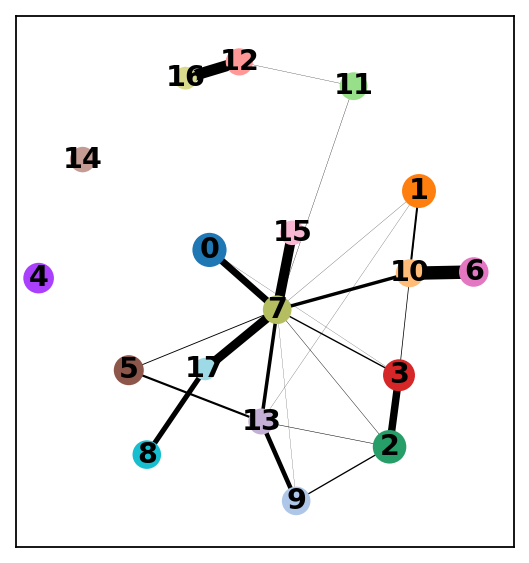

In [16]:
sc.tl.paga(adata_mESC, groups='louvain')
sc.pl.paga(adata_mESC, threshold=0.01, show=False)

# Recomputing the embedding using PAGA-initialization

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:02)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


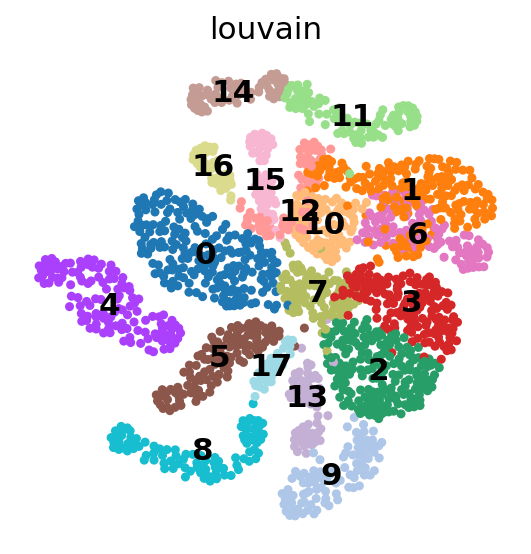

In [17]:
sc.tl.draw_graph(adata_mESC, init_pos='paga')
sc.pl.draw_graph(adata_mESC, color=['louvain'], legend_loc='on data', frameon=False)

/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


--> added 'pos', the PAGA positions (adata.uns['paga'])


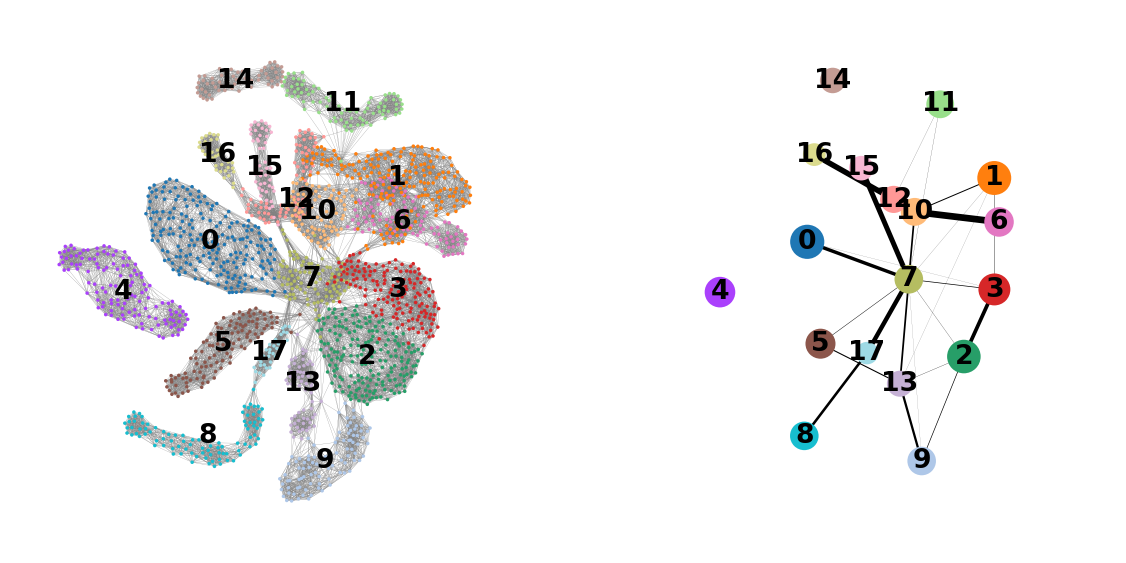

In [18]:
sc.pl.paga_compare(
    adata_mESC, threshold=0.01, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

# Reconstructing PAGA paths

In [19]:
adata_mESC.uns['iroot'] = np.flatnonzero(adata_mESC.obs['louvain']  == '15')[0]

In [20]:
sc.tl.dpt(adata_mESC,n_dcs=10, n_branchings=2, min_group_size=0.01) # Estimate pseudotime

computing Diffusion Pseudotime using n_dcs=10
    this uses a hierarchical implementation
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:00)


In [21]:
adata_raw = sc.read(filename_mESC,cache=True).transpose()#Load raw data
sc.pp.log1p(adata_raw)#Log-transform raw data
sc.pp.scale(adata_raw)#Scale raw data
adata_mESC.raw = adata_raw# add them adata_mESC object

... reading from cache file cache/data-Gastr-Rna_scNMT_gastr.h5ad


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


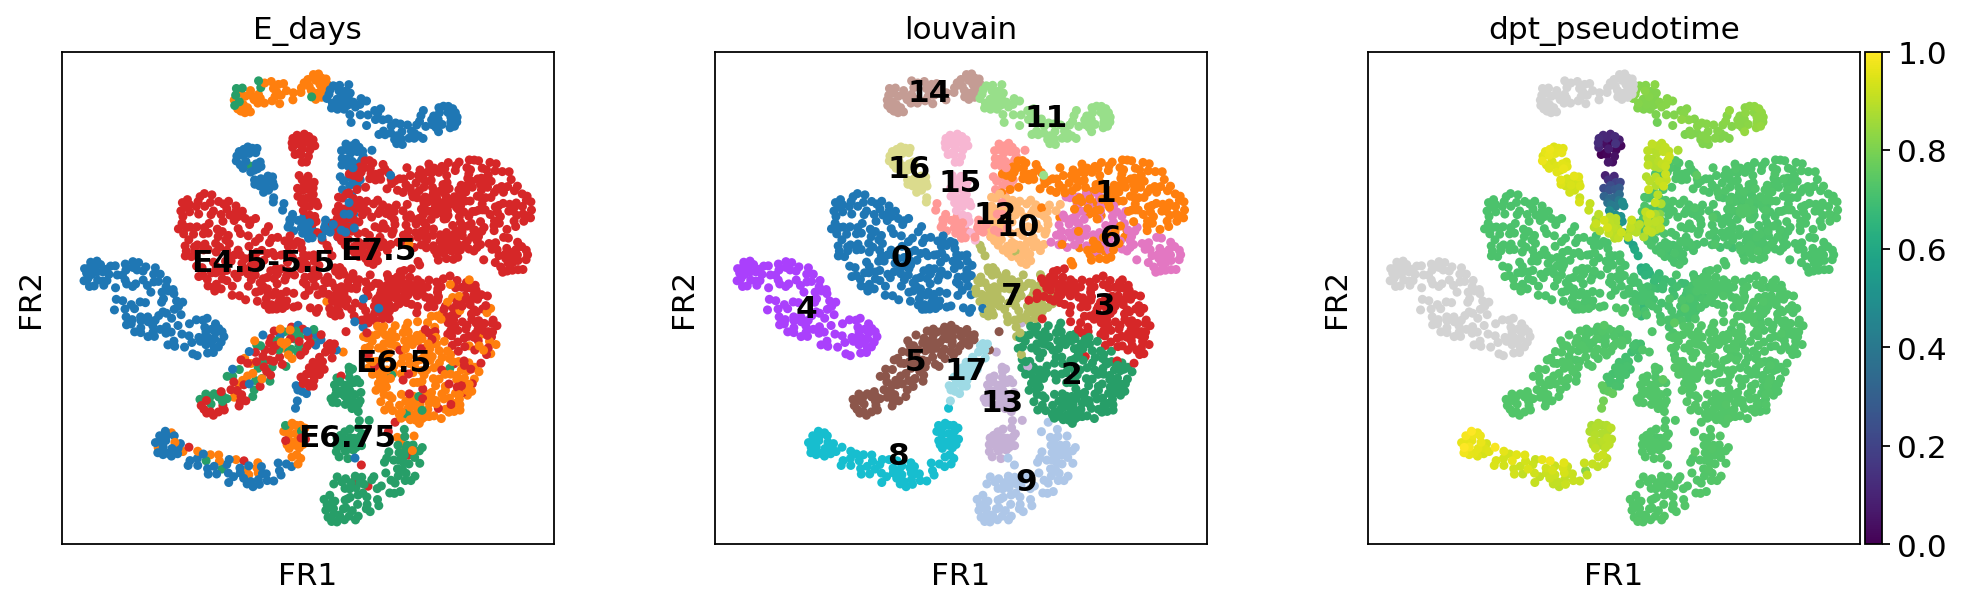

In [22]:
#Compare Ground truth (E_days) with louvain clusters (Louvain) and Defuse pseudotime paths (dpt_pseudotime)
sc.pl.draw_graph(adata_mESC, color=["E_days", 'louvain', 'dpt_pseudotime'], legend_loc='on data')